#### ---------------------- 0. 载入Package ----------------------

In [33]:
!pip install shap

   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 4.9 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]



In [41]:
# ====================== 基础数据处理库 ======================
import pandas as pd
import numpy as np
import os
from collections import Counter  # 计数工具

# ====================== 可视化库 ======================
import matplotlib.pyplot as plt
import seaborn as sns

# ====================== 统计分析库 ======================
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats  # 整合scipy.stats所有功能（替代单独导入的mannwhitneyu等）

# ====================== Word文档处理库 ======================
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.table import WD_TABLE_ALIGNMENT
from docx.oxml.ns import qn

# ====================== 数据插补库 ======================
import miceforest as mf  # MICE插补（备选）
from sklearn.experimental import enable_iterative_imputer  # 启用sklearn迭代插补器（必须保留）
from sklearn.impute import IterativeImputer  # sklearn官方MICE插补

# ====================== 机器学习库（核心） ======================
# 1. 数据划分
from sklearn.model_selection import train_test_split

# 2. 数据预处理
from sklearn.preprocessing import (
    LabelEncoder,       # 标签编码
    OneHotEncoder,      # 独热编码
    StandardScaler      # 标准化
)
from sklearn.compose import ColumnTransformer  # 列转换器（适配不同预处理）
from sklearn.pipeline import Pipeline          # 管道（串联预处理+模型）

# 3. 模型
from sklearn.linear_model import LogisticRegression    # 逻辑回归
from sklearn.ensemble import RandomForestClassifier    # 随机森林
from sklearn.svm import SVC                             # 支持向量机

# 4. 模型评估指标
from sklearn.metrics import (
    accuracy_score, recall_score, roc_auc_score,
    roc_curve, confusion_matrix
)

# 5. 模型解释性分析
import shap

# ====================== 全局设置（解决中文显示/屏蔽警告） ======================
plt.rcParams['font.sans-serif'] = ['SimHei']    # 中文显示
plt.rcParams['axes.unicode_minus'] = False     # 负号显示
import warnings
warnings.filterwarnings('ignore')               # 屏蔽冗余警告

#### ---------------------- 1. 数据读入 ----------------------

In [42]:

# 定义数据路径
biosamples_path = r"D:\keyalei\00-学习\02 博士课程\健康数据Python\final_report\data_resurvey2_biosamples.csv"
questionnaires_path = r"D:\keyalei\00-学习\02 博士课程\健康数据Python\final_report\data_resurvey2_questionnaires.csv"

# 读取两个数据集
try:
    biosamples_df = pd.read_csv(
        biosamples_path, 
        encoding='gbk',          # 优先适配中文系统编码
        engine='python',         # 替换c引擎，兼容不规范格式
        on_bad_lines='skip'      # 跳过字段数不匹配的错误行（新版仅需此参数）
    )  
    questionnaires_df = pd.read_csv(
        questionnaires_path, 
        encoding='gbk',
        engine='python',
        on_bad_lines='skip'
    )
    print("数据读入成功！")
    print(f"生化指标数据行数：{len(biosamples_df)}, 列数：{len(biosamples_df.columns)}")
    print(f"问卷数据行数：{len(questionnaires_df)}, 列数：{len(questionnaires_df.columns)}")
except Exception as e:
    # 若gbk编码失败，尝试utf-8-sig（带BOM的utf-8）
    print(f"GBK编码读入失败，尝试UTF-8-SIG编码：{e}")
    biosamples_df = pd.read_csv(
        biosamples_path, 
        encoding='utf-8-sig',
        engine='python',
        on_bad_lines='skip'
    )
    questionnaires_df = pd.read_csv(
        questionnaires_path, 
        encoding='utf-8-sig',
        engine='python',
        on_bad_lines='skip'
    )
    print("UTF-8-SIG编码读入成功！")
    print(f"生化指标数据行数：{len(biosamples_df)}, 列数：{len(biosamples_df.columns)}")
    print(f"问卷数据行数：{len(questionnaires_df)}, 列数：{len(questionnaires_df.columns)}")

数据读入成功！
生化指标数据行数：25120, 列数：94
问卷数据行数：25239, 列数：31


#### ---------------------- 2. 生化数据清理与质量控制 ----------------------

In [43]:

# 2.1 定义核心生化指标列表
bio_indicators = [
    'alb_gl', 'alt_ul', 'apoa1_mgdl', 'apob_mgdl', 'ast_ul', 'chol_mmoll',
    'crea_umoll', 'cysc_mgl', 'fib_gl', 'ggt_ul', 'hdl_mmoll', 'hscrp_mgl',
    'ldl_mmoll', 'lpa_nmoll', 'tg_mmoll', 'totalvitd_ngml', 'uric_umoll'
]

# 2.2 保留任一生化指标非NA的行（即进行了生化检测的个体）
biosamples_clean = biosamples_df[biosamples_df[bio_indicators].notna().any(axis=1)].copy()

# 2.3 质量控制：保留合格样品（假设haemolysed/turbid/lipaemic/icteric为0=合格，1=不合格）
# 质量控制指标（样品溶血、浑浊、脂血、黄疸状态）
qc_indicators = ['haemolysed', 'turbid', 'lipaemic', 'icteric']
# 保留所有质控指标均为合格（0）的行（若数据中合格标识为其他值，需根据实际调整）
biosamples_qc = biosamples_clean[(biosamples_clean[qc_indicators] == 0).all(axis=1)].copy()


#### ---------------------- 3. 数据合并 ----------------------

In [44]:

# 以质控后的生化数据人群为基础，inner合并确保仅保留双方均有数据的个体
data_merged = pd.merge(
    left=biosamples_qc,  # 质控后的生化数据（基础人群）
    right=questionnaires_df,  # 问卷数据
    on='studyid',  # 链接键
    how='inner'  # 仅保留双方都有studyid的个体
)


#### ---------------------- 4. 数据探索 ----------------------

In [45]:
# 4.0. 路径设置
save_path = r"D:\keyalei\00-学习\02 博士课程\健康数据Python\final_report\result"

# 4.1 基本信息
print("\n===== 基本信息 =====")
print("合并后数据维度（行×列）：", data_merged.shape)
print("\nCOPD诊断结局分布（has_copd）：")
print(Counter(data_merged['has_copd'].fillna('缺失')))

# 4.2 描述性统计
core_vars = [
    'age_at_study_date_x100', 'is_female', 'bmi_calc', 'region_is_urban', 
    'smoking_category', 'cig_equiv_day', 'cooking_start_age', 'mother_copd_etc', 
    'father_copd_etc', 'siblings_copd_etc', 'walking_short_of_breath', 
    'cough_sputum_morning', 'chest_wheeze_whistle', 'asthma_diag', 'tb_diag'
] + bio_indicators + ['has_copd']
core_vars_valid = [col for col in core_vars if col in data_merged.columns]
desc_stats = data_merged[core_vars_valid].describe().round(3)
print("\n===== 核心变量描述性统计 =====")
print(desc_stats)

# 4.3 直方图（保存JPEG）
plt.rcParams["font.sans-serif"] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plot_bio_vars = bio_indicators
fig, axs = plt.subplots(6, 3, constrained_layout=True, figsize=(15, 20), dpi=150)
axs = axs.flatten()
for i, var in enumerate(plot_bio_vars):
    sns.histplot(x=var, data=data_merged.dropna(subset=[var]), alpha=0.4, kde=True, ax=axs[i])
    axs[i].set_title(f"{var} 分布", fontsize=10)
axs[-1].remove()
plt.suptitle("生化指标直方图", fontsize=16)
hist_path = os.path.join(save_path, "生化指标直方图.jpeg")
plt.savefig(hist_path, format='jpeg', dpi=150, bbox_inches='tight')
plt.close()
print(f"\n直方图已保存：{hist_path}")

# 4.4 箱线图+组间统计检验（Mann-Whitney U检验）（保存JPEG）
plt.rcParams["font.sans-serif"] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plot_bio_vars = bio_indicators

# 定义统计检验函数：Mann-Whitney U检验（非参数，适配生化指标分布）
def add_statistical_significance(ax, data, var, group_col='has_copd'):
    """
    在箱线图上添加组间比较的p值和显著性标记
    :param ax: 子图对象
    :param data: 数据框
    :param var: 待检验变量
    :param group_col: 分组列（has_copd）
    """
    # 过滤非缺失值
    data_clean = data.dropna(subset=[var, group_col])
    # 按分组拆分数据
    group_0 = data_clean[data_clean[group_col]==0][var]
    group_1 = data_clean[data_clean[group_col]==1][var]
    
    # 执行Mann-Whitney U检验（H0：两组分布无差异）
    stat, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')
    
    # 标注显著性
    if p_value < 0.001:
        sig = '*** (p<0.001)'
    elif p_value < 0.01:
        sig = '** (p<0.01)'
    elif p_value < 0.05:
        sig = '* (p<0.05)'
    else:
        sig = 'ns (p≥0.05)'
    
    # 在子图顶部添加p值标注
    ax.text(0.5, 0.95, sig, transform=ax.transAxes, ha='center', fontsize=9, weight='bold')
    return p_value

# 绘制箱线图并添加统计检验
fig, axs = plt.subplots(6, 3, constrained_layout=True, figsize=(15, 22), dpi=150)
axs = axs.flatten()
# 存储检验结果
test_results = {}

for i, var in enumerate(plot_bio_vars):
    # 绘制箱线图
    sns.boxplot(
        data=data_merged.dropna(subset=[var, 'has_copd']),
        x='has_copd', y=var, ax=axs[i]
    )
    axs[i].set_title(f"{var} 按COPD分组", fontsize=10)
    # 添加统计检验标注并保存结果
    p_val = add_statistical_significance(axs[i], data_merged, var)
    test_results[var] = p_val

# 删除最后1个多余子图
axs[-1].remove()
plt.suptitle("生化指标按COPD状态分组箱线图（含组间非参数检验）", fontsize=16)

# 保存箱线图
box_path = os.path.join(save_path, "生化指标按COPD分组箱线图（含统计检验）.jpeg")
plt.savefig(box_path, format='jpeg', dpi=150, bbox_inches='tight')
plt.close()
print(f"\n带统计检验的箱线图已保存：{box_path}")

# 输出统计检验结果
print("\n===== 生化指标COPD组间比较（Mann-Whitney U检验） =====")
for var, p_val in test_results.items():
    print(f"{var}: p值 = {p_val:.4f}")


# ---------------------- 生成Word三线表（修复NameError） ----------------------
def create_three_line_table_en(doc, stats_df):
    """创建英文表头的标准统计三线表"""
    # 转置数据（行=变量，列=统计量：count/mean/std/min/25%/50%/75%/max）
    stats_df_T = stats_df.T.reset_index()
    stats_df_T.rename(columns={'index': 'Variable'}, inplace=True)  # 变量名列改为Variable
    n_rows = len(stats_df_T)
    n_cols = len(stats_df_T.columns)
    
    # 创建表格
    table = doc.add_table(rows=n_rows, cols=n_cols)
    table.alignment = WD_TABLE_ALIGNMENT.CENTER
    table.style = 'Table Grid'

    # 填充数据（表头为英文，数据保留3位小数）
    for row_idx in range(n_rows):
        for col_idx in range(n_cols):
            cell = table.cell(row_idx, col_idx)
            # 设置字体（宋体+Times New Roman，适配英文）
            run = cell.paragraphs[0].add_run(str(stats_df_T.iloc[row_idx, col_idx]))
            run.font.name = 'Times New Roman'
            run.font.size = Pt(9)
            run._element.rPr.rFonts.set(qn('w:eastAsia'), '宋体')  # 中文用宋体

    # 设置三线表格式
    for row in table.rows:
        for cell in row.cells:
            cell.width = Inches(1.0)  # 调整列宽适配英文表头
            cell._element.get_or_add_tcPr().append(
                docx.oxml.parse_xml(r'<w:tcBorders xmlns:w="http://schemas.openxmlformats.org/wordprocessingml/2006/main"><w:top w:val="nil"/><w:bottom w:val="nil"/><w:left w:val="nil"/><w:right w:val="nil"/></w:tcBorders>')
            )

    # 添加上边框（粗线）
    table.rows[0]._element.get_or_add_trPr().append(
        docx.oxml.parse_xml(r'<w:trBorders xmlns:w="http://schemas.openxmlformats.org/wordprocessingml/2006/main"><w:top w:val="single" w:sz="12"/><w:bottom w:val="single" w:sz="6"/></w:trBorders>')
    )

    # 添加下边框（粗线）
    table.rows[-1]._element.get_or_add_trPr().append(
        docx.oxml.parse_xml(r'<w:trBorders xmlns:w="http://schemas.openxmlformats.org/wordprocessingml/2006/main"><w:bottom w:val="single" w:sz="12"/></w:trBorders>')
    )

# 创建Word文档并保存
doc = Document()
doc.add_heading('Descriptive Statistics of Core Variables (Three-line Table)', level=1)
create_three_line_table_en(doc, desc_stats)
word_path = os.path.join(save_path, "核心变量描述性统计三线表（英文表头）.docx")
doc.save(word_path)
print(f"英文表头三线表已保存：{word_path}")

print("\n✅ 所有文件保存完成！")


===== 基本信息 =====
合并后数据维度（行×列）： (982, 124)

COPD诊断结局分布（has_copd）：
Counter({0.0: 641, 1.0: 340, '缺失': 1})

===== 核心变量描述性统计 =====
       age_at_study_date_x100  is_female  bmi_calc  region_is_urban  \
count                 982.000    982.000   982.000          982.000   
mean                 6392.036      0.546    23.602            0.269   
std                   974.910      0.498     3.530            0.444   
min                  4103.000      0.000    12.800            0.000   
25%                  5717.500      0.000    21.200            0.000   
50%                  6449.500      1.000    23.300            0.000   
75%                  7132.750      1.000    25.700            1.000   
max                  8410.000      1.000    36.800            1.000   

       smoking_category  cig_equiv_day  cooking_start_age  mother_copd_etc  \
count           981.000        315.000            618.000          975.000   
mean              1.930         18.107             25.976            0.049  

#### ---------------------- 5. 数据预处理 ----------------------

In [46]:
# 基于合并后的数据生成变量
data_model = data_merged.copy()

# ---------------------- 通用工具函数（核心修复逻辑） ----------------------
def get_missing_mask(df, depend_vars):
    """创建缺失值掩码（True=任一依赖变量缺失）"""
    exist_vars = [var for var in depend_vars if var in df.columns]
    mask = df[exist_vars].isna().any(axis=1)
    return mask

def safe_categorical_assign(df, var_name, depend_vars, assign_func):
    """
    安全生成分类变量：解决字符串+np.nan的dtype冲突
    :param df: 数据框
    :param var_name: 新变量名
    :param depend_vars: 依赖的原始变量列表
    :param assign_func: 生成变量的函数（返回全字符串结果，用'__MISSING__'标识缺失）
    """
    # 1. 获取原始变量缺失掩码
    mask = get_missing_mask(df, depend_vars)
    # 2. 执行赋值函数（返回全字符串，无np.nan）
    df[var_name] = assign_func(df)
    # 3. 替换临时缺失标识为np.nan
    df[var_name] = df[var_name].replace('__MISSING__', np.nan)
    # 4. 应用原始变量缺失掩码（原始缺失→新变量缺失）
    df.loc[mask, var_name] = np.nan
    # 5. 强制转为object类型
    df[var_name] = df[var_name].astype('object')

# ---------------------- 1. 人口学特征变量 ----------------------
# Age：年龄
depend_age = ['age_at_study_date_x100']
mask_age = get_missing_mask(data_model, depend_age)
data_model['Age'] = data_model['age_at_study_date_x100'] / 100
data_model.loc[mask_age, 'Age'] = np.nan
data_model['Age'] = pd.to_numeric(data_model['Age'], errors='coerce')

# Sex：性别
def assign_sex(df):
    return df['is_female'].map({0: 'Male', 1: 'Female'}).fillna('__MISSING__')
safe_categorical_assign(data_model, 'Sex', ['is_female'], assign_sex)

# Location：城乡位置
def assign_location(df):
    return df['region_is_urban'].map({0: 'Rural', 1: 'Urban'}).fillna('__MISSING__')
safe_categorical_assign(data_model, 'Location', ['region_is_urban'], assign_location)

# Region：地理区域
def assign_region(df):
    region_conditions = [
        df['region_code'] == 52,
        df['region_code'].isin([26, 46]),
        df['region_code'].isin([12, 36, 78]),
        df['region_code'].isin([88, 68]),
        df['region_code'] == 58,
        df['region_code'] == 16
    ]
    region_values = ['Southwest', 'South', 'East', 'Central', 'Northwest', 'Northeast']
    return np.select(region_conditions, region_values, default='__MISSING__')
safe_categorical_assign(data_model, 'Region', ['region_code'], assign_region)

# Education：教育程度
def assign_education(df):
    edu_conditions = [
        df['highest_education'].isin([0, 1]),
        df['highest_education'].isin([2, 3]),
        df['highest_education'].isin([4, 5])
    ]
    edu_values = ['Primary school and below', 'Middle school and high school', 'College graduates and above']
    return np.select(edu_conditions, edu_values, default='__MISSING__')
safe_categorical_assign(data_model, 'Education', ['highest_education'], assign_education)

# ---------------------- 2. 生活方式与暴露变量 ----------------------
# Current Smoker：当前吸烟状态
def assign_current_smoker(df):
    return np.where(
        df['smoking_category'].isin([1, 2, 3]), 'No',
        np.where(df['smoking_category'] == 4, 'Yes', '__MISSING__')  # 用字符串代替np.nan
    )
safe_categorical_assign(data_model, 'Current_Smoker', ['smoking_category'], assign_current_smoker)

# Smoking amount (pack-years)：吸烟量（数值型）
depend_smoking_amt = ['smoking_category']
mask_smoking_amt = get_missing_mask(data_model, depend_smoking_amt)
data_model['Smoking_pack_years'] = np.where(
    data_model['smoking_category'].isin([1, 2, 3]), 0,
    pd.to_numeric(data_model['cig_equiv_day'], errors='coerce')
)
data_model.loc[mask_smoking_amt, 'Smoking_pack_years'] = np.nan
data_model['Smoking_pack_years'] = pd.to_numeric(data_model['Smoking_pack_years'], errors='coerce')

# Cooking fuel exposure years：烹饪燃料暴露年限（数值型）
depend_cooking_exp = ['cooking_fuel_present']
mask_cooking_exp = get_missing_mask(data_model, depend_cooking_exp)
data_model['Cooking_fuel_exposure_years'] = np.where(
    data_model['cooking_fuel_present'].isin([1, 2]),
    (data_model['age_at_study_date_x100'] / 100) - data_model['cooking_start_age'],
    0
)
data_model.loc[mask_cooking_exp, 'Cooking_fuel_exposure_years'] = np.nan
data_model['Cooking_fuel_exposure_years'] = pd.to_numeric(data_model['Cooking_fuel_exposure_years'], errors='coerce')

# Cooking fuel exposure group：暴露年限分组
mask_cooking_group = data_model['Cooking_fuel_exposure_years'].isna()
data_model['Cooking_fuel_exposure_group'] = pd.cut(
    data_model['Cooking_fuel_exposure_years'],
    bins=[-1, 30, 60, np.inf],
    labels=['0–30', '31–60', '≥61'],
    include_lowest=True
).astype('object').fillna('__MISSING__')
data_model['Cooking_fuel_exposure_group'] = data_model['Cooking_fuel_exposure_group'].replace('__MISSING__', np.nan)
data_model.loc[mask_cooking_group, 'Cooking_fuel_exposure_group'] = np.nan

# ---------------------- 3. 病史与家族史变量 ----------------------
# Family history of COPD：COPD家族史
def assign_family_copd(df):
    return np.where(
        (df['mother_copd_etc'] > 0) | (df['father_copd_etc'] > 0) | (df['siblings_copd_etc'] > 0),
        'Yes',
        np.where(
            (df['mother_copd_etc'] <= 0) & (df['father_copd_etc'] <= 0) & (df['siblings_copd_etc'] <= 0),
            'No', '__MISSING__'
        )
    )
safe_categorical_assign(data_model, 'Family_history_COPD', 
                        ['mother_copd_etc', 'father_copd_etc', 'siblings_copd_etc'], 
                        assign_family_copd)

# History of tuberculosis：肺结核病史
def assign_tb_history(df):
    return np.where(
        df['tb_diag'] == 1, 'Yes',
        np.where(df['tb_diag'] == 0, 'No', '__MISSING__')
    )
safe_categorical_assign(data_model, 'History_tuberculosis', ['tb_diag'], assign_tb_history)

# ---------------------- 4. 身体指标与症状变量 ----------------------
# BMI group：BMI分组
mask_bmi = get_missing_mask(data_model, ['bmi_calc'])
data_model['BMI_group'] = pd.cut(
    pd.to_numeric(data_model['bmi_calc'], errors='coerce'),
    bins=[-np.inf, 18.5, 23.9, 27.9, np.inf],
    labels=['<18.5', '18.5–23.9', '24.0–27.9', '≥28'],
    include_lowest=True
).astype('object').fillna('__MISSING__')
data_model['BMI_group'] = data_model['BMI_group'].replace('__MISSING__', np.nan)
data_model.loc[mask_bmi, 'BMI_group'] = np.nan

# Shortness of breath：气短
def assign_shortness_breath(df):
    return np.where(
        df['walking_short_of_breath'] == 0, 'No',
        np.where(df['walking_short_of_breath'] >= 1, 'Yes', '__MISSING__')
    )
safe_categorical_assign(data_model, 'Shortness_of_breath', ['walking_short_of_breath'], assign_shortness_breath)

# Sputum：咳痰
def assign_sputum(df):
    return np.where(
        df['cough_sputum_morning'] == 0, 'No',
        np.where(df['cough_sputum_morning'] >= 1, 'Yes', '__MISSING__')
    )
safe_categorical_assign(data_model, 'Sputum', ['cough_sputum_morning'], assign_sputum)

# Wheeze：喘息
def assign_wheeze(df):
    return np.where(
        df['chest_wheeze_whistle'] == 0, 'No',
        np.where(df['chest_wheeze_whistle'] >= 1, 'Yes', '__MISSING__')
    )
safe_categorical_assign(data_model, 'Wheeze', ['chest_wheeze_whistle'], assign_wheeze)

# ---------------------- 最终验证 ----------------------
core_pred_vars = [
    'Age', 'Sex', 'Location', 'Region', 'Education', 'Current_Smoker',
    'Smoking_pack_years', 'Cooking_fuel_exposure_years', 'Cooking_fuel_exposure_group',
    'Family_history_COPD', 'History_tuberculosis', 'BMI_group', 'Shortness_of_breath', 'Sputum', 'Wheeze'
]

# 缺失值统计
missing_stats = pd.DataFrame({
    '变量名': core_pred_vars,
    '总样本数': len(data_model),
    '非缺失值数': [data_model[var].notna().sum() for var in core_pred_vars],
    '缺失值数': [data_model[var].isna().sum() for var in core_pred_vars],
    '缺失率(%)': [round(data_model[var].isna().mean()*100, 2) for var in core_pred_vars]
})

print("===== 核心变量缺失值统计（原始变量缺失→新变量缺失） =====")
print(missing_stats)


===== 核心变量缺失值统计（原始变量缺失→新变量缺失） =====
                            变量名  总样本数  非缺失值数  缺失值数  缺失率(%)
0                           Age   982    982     0    0.00
1                           Sex   982    982     0    0.00
2                      Location   982    982     0    0.00
3                        Region   982    982     0    0.00
4                     Education   982    982     0    0.00
5                Current_Smoker   982    981     1    0.10
6            Smoking_pack_years   982    981     1    0.10
7   Cooking_fuel_exposure_years   982    817   165   16.80
8   Cooking_fuel_exposure_group   982    817   165   16.80
9           Family_history_COPD   982    940    42    4.28
10         History_tuberculosis   982    981     1    0.10
11                    BMI_group   982    982     0    0.00
12          Shortness_of_breath   982    981     1    0.10
13                       Sputum   982    981     1    0.10
14                       Wheeze   982    981     1    0.10


#### ---------------------- 6. 变量描述 ----------------------

In [47]:
vars_to_analyze = [
    # 问卷生成变量
    'Age', 'Sex', 'Location', 'Region', 'Education', 'Current_Smoker',
    'Smoking_pack_years', 'Cooking_fuel_exposure_group', 'Family_history_COPD',
    'History_tuberculosis', 'BMI_group', 'Shortness_of_breath', 'Sputum', 'Wheeze',
    # 生化指标变量
    'alb_gl', 'alt_ul', 'apoa1_mgdl', 'apob_mgdl', 'ast_ul', 'chol_mmoll',
    'crea_umoll', 'cysc_mgl', 'fib_gl', 'ggt_ul', 'hdl_mmoll', 'hscrp_mgl',
    'ldl_mmoll', 'lpa_nmoll', 'tg_mmoll', 'totalvitd_ngml', 'uric_umoll'
]

# 区分分类/连续变量（用于差异化统计和检验）
categorical_vars = [
    'Sex', 'Location', 'Region', 'Education', 'Current_Smoker',
    'Cooking_fuel_exposure_group', 'Family_history_COPD', 'History_tuberculosis',
    'BMI_group', 'Shortness_of_breath', 'Sputum', 'Wheeze'
]
continuous_vars = [var for var in vars_to_analyze if var not in categorical_vars]

# 数据准备：仅保留has_copd为0/1的行，过滤异常值
data_analyze = data_model.copy()
# 确保has_copd为数值型，过滤非0/1的行
data_analyze['has_copd'] = pd.to_numeric(data_analyze['has_copd'], errors='coerce')
data_analyze = data_analyze[data_analyze['has_copd'].isin([0, 1])].reset_index(drop=True)

# ---------------------- 2. 定义核心统计+检验函数 ----------------------
def analyze_categorical(var, df):
    """
    分类变量分析：描述统计（构成比）+ 卡方检验 + 缺失值统计
    """
    result = {
        '变量名': var,
        '变量类型': '分类变量',
        '检验方法': '卡方检验',
        'COPD=0_描述': '',
        'COPD=0_缺失值个数': 0,
        'COPD=1_描述': '',
        'COPD=1_缺失值个数': 0,
        '检验统计量（卡方值）': np.nan,
        'P值': np.nan,
        '检验备注': ''
    }

    # 1. 缺失值统计
    for copd_val in [0, 1]:
        group = df[df['has_copd'] == copd_val]
        na_count = group[var].isna().sum()
        result[f'COPD={copd_val}_缺失值个数'] = na_count

    # 2. 描述统计（构成比）
    for copd_val in [0, 1]:
        group = df[df['has_copd'] == copd_val]
        non_na_group = group[group[var].notna()]
        if len(non_na_group) == 0:
            result[f'COPD={copd_val}_描述'] = '无有效数据'
            continue
        
        count = non_na_group[var].value_counts()
        total = len(non_na_group)
        desc_parts = []
        for cat, cnt in count.items():
            pct = round((cnt / total) * 100, 1)
            desc_parts.append(f"{cnt} ({pct}%)")
        result[f'COPD={copd_val}_描述'] = '; '.join(desc_parts)

    # 3. 卡方检验（仅当有足够有效数据时执行）
    # 构建列联表：变量类别 × COPD分组（排除缺失值）
    non_na_df = df[df[var].notna()]
    if len(non_na_df) < 5:  # 样本量不足
        result['检验备注'] = '样本量不足，无法检验'
        return result
    
    # 构建列联表
    contingency_table = pd.crosstab(non_na_df[var], non_na_df['has_copd'])
    # 检查期望频数（卡方检验要求：期望频数<5的单元格≤20%）
    expected = chi2_contingency(contingency_table)[3]
    low_exp_count = (expected < 5).sum()
    total_cell = expected.size
    if low_exp_count / total_cell > 0.2:
        result['检验备注'] = '期望频数不足，结果可能不准确'
    
    # 执行卡方检验
    try:
        chi2, p, dof, _ = chi2_contingency(contingency_table)
        result['检验统计量（卡方值）'] = round(chi2, 4)
        result['P值'] = round(p, 4)
        # 标注P值极值（如P<0.0001）
        if result['P值'] < 0.0001:
            result['P值'] = '<0.0001'
    except Exception as e:
        result['检验备注'] = f'检验失败：{str(e)[:50]}'

    return result

def analyze_continuous(var, df):
    """
    连续变量分析：描述统计（均数±SD）+ 独立样本t检验 + 缺失值统计
    """
    result = {
        '变量名': var,
        '变量类型': '连续变量',
        '检验方法': '独立样本t检验',
        'COPD=0_描述': '',
        'COPD=0_缺失值个数': 0,
        'COPD=1_描述': '',
        'COPD=1_缺失值个数': 0,
        '检验统计量（t值）': np.nan,
        'P值': np.nan,
        '检验备注': ''
    }

    # 1. 缺失值统计
    for copd_val in [0, 1]:
        group = df[df['has_copd'] == copd_val]
        na_count = group[var].isna().sum()
        result[f'COPD={copd_val}_缺失值个数'] = na_count

    # 2. 描述统计（均数±SD）
    for copd_val in [0, 1]:
        group = df[df['has_copd'] == copd_val]
        non_na_vals = group[var].dropna()
        if len(non_na_vals) == 0:
            result[f'COPD={copd_val}_描述'] = '无有效数据'
            continue
        
        mean_val = round(non_na_vals.mean(), 2)
        sd_val = round(non_na_vals.std(), 2)
        result[f'COPD={copd_val}_描述'] = f"{mean_val} ({sd_val})"

    # 3. 独立样本t检验（仅当有足够有效数据时执行）
    # 提取两组非缺失值
    vals_0 = df[df['has_copd'] == 0][var].dropna()
    vals_1 = df[df['has_copd'] == 1][var].dropna()
    if len(vals_0) < 3 or len(vals_1) < 3:  # 每组样本量不足
        result['检验备注'] = '单组样本量不足，无法检验'
        return result
    
    # 执行t检验（Welch's t检验，不假设方差齐性）
    try:
        t_stat, p_val = ttest_ind(vals_0, vals_1, equal_var=False, nan_policy='omit')
        result['检验统计量（t值）'] = round(t_stat, 4)
        result['P值'] = round(p_val, 4)
        # 标注P值极值
        if result['P值'] < 0.0001:
            result['P值'] = '<0.0001'
    except Exception as e:
        result['检验备注'] = f'检验失败：{str(e)[:50]}'

    return result

# ---------------------- 3. 批量分析所有变量 ----------------------
analyze_results = []

# 分析分类变量
for var in categorical_vars:
    if var in data_analyze.columns:
        analyze_results.append(analyze_categorical(var, data_analyze))
    else:
        # 变量不存在时填充默认值
        analyze_results.append({
            '变量名': var,
            '变量类型': '分类变量',
            '检验方法': '卡方检验',
            'COPD=0_描述': '变量不存在',
            'COPD=0_缺失值个数': np.nan,
            'COPD=1_描述': '变量不存在',
            'COPD=1_缺失值个数': np.nan,
            '检验统计量（卡方值）': np.nan,
            'P值': np.nan,
            '检验备注': '变量不存在'
        })

# 分析连续变量
for var in continuous_vars:
    if var in data_analyze.columns:
        analyze_results.append(analyze_continuous(var, data_analyze))
    else:
        # 变量不存在时填充默认值
        analyze_results.append({
            '变量名': var,
            '变量类型': '连续变量',
            '检验方法': '独立样本t检验',
            'COPD=0_描述': '变量不存在',
            'COPD=1_描述': '变量不存在',
            'COPD=0_缺失值个数': np.nan,
            'COPD=1_缺失值个数': np.nan,
            '检验统计量（t值）': np.nan,
            'P值': np.nan,
            '检验备注': '变量不存在'
        })

# 转换为DataFrame并排序
analyze_df = pd.DataFrame(analyze_results)
analyze_df = analyze_df.sort_values('变量名').reset_index(drop=True)

# ---------------------- 4. 保存为CSV文件（支持中文显示） ----------------------
csv_filename = "变量按COPD分组描述+假设检验结果.csv"
csv_path = os.path.join(save_path, csv_filename)
# 保存时指定编码，避免中文乱码
analyze_df.to_csv(csv_path, encoding='utf-8-sig', index=False)

# ---------------------- 5. 结果预览 ----------------------
print("===== 变量分析结果预览（前10行） =====")
print(analyze_df[['变量名', '变量类型', 'COPD=0_描述', 'COPD=1_描述', 'P值']].head(10))
print(f"\n===== 完整结果已保存至：{csv_path} =====")
print(f"分析变量总数：{len(analyze_df)}（分类变量{len(categorical_vars)}个，连续变量{len(continuous_vars)}个）")

PermissionError: [Errno 13] Permission denied: 'D:\\keyalei\\00-学习\\02 博士课程\\健康数据Python\\final_report\\result\\变量按COPD分组描述+假设检验结果.csv'

#### ---------------------- 7. 缺失值处理 ----------------------

In [ ]:
# ---------------------- 1. 基础配置与数据强预处理 ----------------------
# 待插补变量列表
vars_to_impute = [
    'Age', 'Sex', 'Location', 'Region', 'Education', 'Current_Smoker',
    'Smoking_pack_years', 'Cooking_fuel_exposure_group', 'Family_history_COPD',
    'History_tuberculosis', 'BMI_group', 'Shortness_of_breath', 'Sputum', 'Wheeze',
    'alb_gl', 'alt_ul', 'apoa1_mgdl', 'apob_mgdl', 'ast_ul', 'chol_mmoll',
    'crea_umoll', 'cysc_mgl', 'fib_gl', 'ggt_ul', 'hdl_mmoll', 'hscrp_mgl',
    'ldl_mmoll', 'lpa_nmoll', 'tg_mmoll', 'totalvitd_ngml', 'uric_umoll',
    'has_copd'
]

# 读取原始数据
data_impute = data_analyze.copy()[vars_to_impute]

# 第一步：替换无限值+过滤目标变量
data_impute = data_impute.replace([np.inf, -np.inf], np.nan)
data_impute['has_copd'] = pd.to_numeric(data_impute['has_copd'], errors='coerce')
data_impute = data_impute[data_impute['has_copd'].isin([0, 1])].reset_index(drop=True)

# 第二步：强化分类变量缺失值预处理（关键：先填充众数，再标记临时缺失）
categorical_vars = [
    'Sex', 'Location', 'Region', 'Education', 'Current_Smoker',
    'Cooking_fuel_exposure_group', 'Family_history_COPD', 'History_tuberculosis',
    'BMI_group', 'Shortness_of_breath', 'Sputum', 'Wheeze'
]

# 先填充分类变量的缺失值为“众数”
for col in categorical_vars:
    # 计算众数（处理多众数情况，取第一个）
    mode_val = data_impute[col].mode()[0] if not data_impute[col].mode().empty else "未知"
    # 先填充众数，再标记剩余极端缺失为TEMP_MISS
    data_impute[col] = data_impute[col].fillna(mode_val).astype(str)
    data_impute[col] = data_impute[col].replace("", "TEMP_MISS")  # 空字符串也标记

# 第三步：数值变量处理
for col in data_impute.select_dtypes(include=['int64']).columns:
    data_impute[col] = data_impute[col].astype(float)

# ---------------------- 2. 分类变量编码 ----------------------
le_dict = {}
for col in categorical_vars:
    le = LabelEncoder()
    # 编码（包含TEMP_MISS）
    data_impute[col] = le.fit_transform(data_impute[col])
    le_dict[col] = le

# ---------------------- 3. 强化MICE插补（参数优化） ----------------------
imputer = IterativeImputer(
    random_state=123,
    max_iter=10,                # 增加迭代次数，确保收敛
    n_nearest_features=10,      # 增加特征数，提升插补准确性
    initial_strategy='most_frequent',  # 初始填充用众数（分类变量友好）
    verbose=0
)

# 执行插补
imputed_data_np = imputer.fit_transform(data_impute)
data_imputed_main = pd.DataFrame(imputed_data_np, columns=data_impute.columns)

# 生成5个插补数据集
imputed_datasets = []
for i in range(5):
    imputer_i = IterativeImputer(
        random_state=123 + i,
        max_iter=10,
        n_nearest_features=10,
        initial_strategy='most_frequent'
    )
    imputed_np_i = imputer_i.fit_transform(data_impute)
    imputed_df_i = pd.DataFrame(imputed_np_i, columns=data_impute.columns)
    imputed_datasets.append(imputed_df_i)

# ---------------------- 4. 逆编码+强制填充剩余缺失值 ----------------------
# 主数据集处理
for col in categorical_vars:
    if col in data_imputed_main.columns:
        # 插补后取整，确保是有效编码值
        data_imputed_main[col] = data_imputed_main[col].round().astype(int)
        # 限制编码值在LabelEncoder的范围内（避免越界）
        max_code = len(le_dict[col].classes_) - 1
        data_imputed_main[col] = np.clip(data_imputed_main[col], 0, max_code)
        # 逆编码
        data_imputed_main[col] = le_dict[col].inverse_transform(data_imputed_main[col])
        # 最后强制填充剩余缺失值为众数
        mode_val = data_analyze[col].mode()[0] if not data_analyze[col].mode().empty else "未知"
        data_imputed_main[col] = data_imputed_main[col].replace("TEMP_MISS", mode_val).fillna(mode_val)

# 所有插补数据集处理
for imp_data in imputed_datasets:
    for col in categorical_vars:
        if col in imp_data.columns:
            imp_data[col] = imp_data[col].round().astype(int)
            max_code = len(le_dict[col].classes_) - 1
            imp_data[col] = np.clip(imp_data[col], 0, max_code)
            imp_data[col] = le_dict[col].inverse_transform(imp_data[col])
            mode_val = data_analyze[col].mode()[0] if not data_analyze[col].mode().empty else "未知"
            imp_data[col] = imp_data[col].replace("TEMP_MISS", mode_val).fillna(mode_val)

# ---------------------- 5. 验证+保存 ----------------------
missing_after = data_imputed_main.isna().sum()[vars_to_impute[:-1]]
print("===== 插补效果验证 =====")
print(f"插补后剩余缺失值变量数：{len(missing_after[missing_after > 0])}")
if len(missing_after[missing_after > 0]) > 0:
    print("剩余缺失值：", missing_after[missing_after > 0])
else:
    print("✅ 所有变量无缺失值！")

# 保存
main_path = os.path.join(save_path, "MICE插补主数据集_最终版.csv")
data_imputed_main.to_csv(main_path, encoding='utf-8-sig', index=False)
for i, imp_data in enumerate(imputed_datasets):
    imp_path = os.path.join(save_path, f"MICE插补数据集_{i+1}.csv")
    imp_data.to_csv(imp_path, encoding='utf-8-sig', index=False)
print(f"\n🎉 插补完成！主数据集保存至：{main_path}")

#### ---------------------- 8. 生化指标与 COPD 关联的逻辑回归分析 ----------------------

In [49]:
data_reg = data_imputed_main.copy()

# 数据预处理与校验（确保逻辑回归输入有效）
print("===== 数据基本校验 =====")
# 3.1 定义因变量（二元）和自变量（17个生化指标）
target_var = "has_copd"  # 0=无COPD，1=有COPD（二元因变量）
bio_vars = [
    'alb_gl', 'alt_ul', 'apoa1_mgdl', 'apob_mgdl', 'ast_ul', 'chol_mmoll',
    'crea_umoll', 'cysc_mgl', 'fib_gl', 'ggt_ul', 'hdl_mmoll', 'hscrp_mgl',
    'ldl_mmoll', 'lpa_nmoll', 'tg_mmoll', 'totalvitd_ngml', 'uric_umoll'
]

# 3.2 校验变量存在性
missing_vars = [var for var in bio_vars + [target_var] if var not in data_reg.columns]
if missing_vars:
    raise ValueError(f"数据缺失关键变量：{missing_vars}，请检查列名！")
print(f"✅ 因变量和17个生化指标均存在")

# 3.3 数据类型与有效性校验
data_reg[target_var] = pd.to_numeric(data_reg[target_var], errors='coerce')
for var in bio_vars:
    data_reg[var] = pd.to_numeric(data_reg[var], errors='coerce')
# 过滤无效样本（仅保留has_copd=0/1，逻辑回归必需）
data_reg = data_reg[data_reg[target_var].isin([0, 1])].reset_index(drop=True)
print(f"✅ 有效样本量（预处理后）：{len(data_reg)}")
print(f"✅ 无缺失值（MICE插补效果）：{data_reg[bio_vars + [target_var]].isna().sum().sum() == 0}")

# 4. 构建并拟合逻辑回归模型（smf.logit()）
print("\n===== 逻辑回归模型构建与拟合 =====")
# 4.1 模型公式
formula = f"{target_var} ~ " + " + ".join(bio_vars)
print(f"模型公式：{formula}")

# 4.2 定义+拟合模型（disp=0屏蔽迭代日志）
model = smf.logit(formula=formula, data=data_reg)
model_fit = model.fit(disp=0)

# 5. 打印模型核心结果（修复样本量获取方式）
print("\n===== 逻辑回归模型核心结果预览 =====")
print(f"1. 模型收敛状态：{'收敛' if model_fit.converged else '未收敛'}")
# 修复：用model_fit.nobs获取样本量（statsmodels通用属性，返回拟合时的观测数）
print(f"2. 拟合样本量：{int(model_fit.nobs)}")  
print(f"3. McFadden R²（拟合优度）：{model_fit.prsquared:.4f}（0.2-0.4为较好拟合）")
print(f"4. AIC（模型复杂度指标）：{model_fit.aic:.2f}（值越小模型越优）")

# 6. 提取回归结果并写入CSV（核心需求）
print("\n===== 提取结果并写入CSV =====")
# 6.1 提取系数表（含OR值和95%CI，逻辑回归关键）
coef_table = model_fit.summary2().tables[1].copy()
coef_table.reset_index(inplace=True)
coef_table.rename(columns={'index': '变量名'}, inplace=True)

# 6.2 新增逻辑回归核心指标（OR值及95%CI）
coef_table['优势比(OR)'] = np.exp(coef_table['Coef.'])  # OR = 系数的指数
coef_table['OR_95%CI_下限'] = np.exp(coef_table['[0.025'])
coef_table['OR_95%CI_上限'] = np.exp(coef_table['0.975]'])

# 6.3 筛选+重命名核心列（中文友好）
core_cols = [
    '变量名', 'Coef.', 'Std.Err.', 'z', 'P>|z|', 
    '优势比(OR)', 'OR_95%CI_下限', 'OR_95%CI_上限'
]
coef_result = coef_table[core_cols].copy()
coef_result.rename(columns={
    'Coef.': '回归系数',
    'Std.Err.': '标准误',
    'z': 'z值',
    'P>|z|': 'p值'
}, inplace=True)

# 6.4 标记显著性（p<0.05为显著）
coef_result['显著性'] = coef_result['p值'].apply(
    lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else 'ns'))
)

# 6.5 写入系数结果CSV
coef_csv_path = os.path.join(save_path, "生化指标逻辑回归系数结果.csv")
coef_result.to_csv(coef_csv_path, encoding='utf-8-sig', index=False)
print(f"✅ 系数结果已保存至：{coef_csv_path}")

# 6.6 写入模型整体信息CSV（溯源用）
model_info = pd.DataFrame({
    '模型类型': ['逻辑回归（smf.logit()）'],
    '因变量': [target_var],
    '自变量数量': [len(bio_vars)],
    '拟合样本量': [int(model_fit.nobs)],  # 修复后的值
    '收敛状态': ['收敛' if model_fit.converged else '未收敛'],
    'McFadden R²': [round(model_fit.prsquared, 4)],
    'AIC': [round(model_fit.aic, 2)],
    'BIC': [round(model_fit.bic, 2)],
    '拟合时间': [pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')]
})

model_info_csv_path = os.path.join(save_path, "逻辑回归模型整体信息.csv")
model_info.to_csv(model_info_csv_path, encoding='utf-8-sig', index=False)
print(f"✅ 模型整体信息已保存至：{model_info_csv_path}")

===== 数据基本校验 =====
✅ 因变量和17个生化指标均存在
✅ 有效样本量（预处理后）：981
✅ 无缺失值（MICE插补效果）：True

===== 逻辑回归模型构建与拟合 =====
模型公式：has_copd ~ alb_gl + alt_ul + apoa1_mgdl + apob_mgdl + ast_ul + chol_mmoll + crea_umoll + cysc_mgl + fib_gl + ggt_ul + hdl_mmoll + hscrp_mgl + ldl_mmoll + lpa_nmoll + tg_mmoll + totalvitd_ngml + uric_umoll

===== 逻辑回归模型核心结果预览 =====
1. 模型收敛状态：收敛
2. 拟合样本量：981
3. McFadden R²（拟合优度）：0.0859（0.2-0.4为较好拟合）
4. AIC（模型复杂度指标）：1193.32（值越小模型越优）

===== 提取结果并写入CSV =====
✅ 系数结果已保存至：D:\keyalei\00-学习\02 博士课程\健康数据Python\final_report\result\生化指标逻辑回归系数结果.csv
✅ 模型整体信息已保存至：D:\keyalei\00-学习\02 博士课程\健康数据Python\final_report\result\逻辑回归模型整体信息.csv


#### ---------------------- 9. 预测模型建立、评估与可视化 ----------------------

In [51]:

# 2. 路径设置
save_path = r"D:\keyalei\00-学习\02 博士课程\健康数据Python\final_report\result"
vis_path = os.path.join(save_path, "模型可视化图表")
os.makedirs(vis_path, exist_ok=True)

# 3. 数据准备（严格按需求处理）
# 3.1 读取数据
try:
    data = data_reg.copy()
except NameError:
    data_path = os.path.join(save_path, "MICE插补主数据集_最终版.csv")
    data = pd.read_csv(data_path, encoding='utf-8-sig')
print("===== 数据加载成功！====")

# 3.2 定义变量
base_vars = [
    'Age', 'Sex', 'Location', 'Region', 'Education', 'Current_Smoker',
    'Smoking_pack_years', 'Cooking_fuel_exposure_group', 'Family_history_COPD',
    'History_tuberculosis', 'BMI_group', 'Shortness_of_breath', 'Sputum', 'Wheeze'
]
bio_vars_single = ['alb_gl', 'chol_mmoll', 'cysc_mgl', 'fib_gl',  'hdl_mmoll', 'totalvitd_ngml']
target_var = 'has_copd'

# 3.3 校验所有必需变量存在性
all_needed_vars = base_vars + bio_vars_single + [target_var]
missing_vars = [var for var in all_needed_vars if var not in data.columns]
if missing_vars:
    raise ValueError(f"❌ 数据集缺少必需变量：{missing_vars}\n请核对列名一致性！")
print("✅ 所有基础变量和生化指标均存在！")

# 3.4 分离X（仅包含需要的变量：基础+6个特定生化）和y
X = data[base_vars + bio_vars_single].copy()
y = data[target_var].copy()

# 3.5 处理缺失值和有效样本
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].fillna('缺失值').astype(str)
y = y.fillna(-1).astype(int)
valid_mask = y.isin([0, 1])
X = X[valid_mask].reset_index(drop=True)
y = y[valid_mask].reset_index(drop=True)
print(f"✅ 有效样本量：{len(X)}（y=0/1）")

# 3.6 划分训练集/测试集（仅划分一次，后续模型从这里筛选特征）
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# 重置索引确保对齐
X_train_raw = X_train_raw.reset_index(drop=True)
X_test_raw = X_test_raw.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print(f"✅ 训练集形状：{X_train_raw.shape}，测试集形状：{X_test_raw.shape}")

# 4. 核心工具函数（修改：每个模型单独构建预处理管道）
# 4.1 NRI计算函数（不变）
def calculate_nri(base_probs, new_probs, y_true, base_probs_train, y_train):
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, base_probs_train)
    youden_idx = np.argmax(tpr_train - fpr_train)
    threshold = thresholds_train[youden_idx]
    base_pred = (base_probs >= threshold).astype(int)
    new_pred = (new_probs >= threshold).astype(int)
    pos_total = (y_true == 1).sum()
    neg_total = (y_true == 0).sum()
    up_pos = ((y_true == 1) & (base_pred == 0) & (new_pred == 1)).sum() / pos_total
    down_pos = ((y_true == 1) & (base_pred == 1) & (new_pred == 0)).sum() / pos_total
    down_neg = ((y_true == 0) & (base_pred == 1) & (new_pred == 0)).sum() / neg_total
    up_neg = ((y_true == 0) & (base_pred == 0) & (new_pred == 1)).sum() / neg_total
    return round((up_pos - down_pos) + (down_neg - up_neg), 4)

# 4.2 模型训练与评估函数
def train_evaluate_model(model, X_train_full, X_test_full, y_train, y_test, current_vars):
    """
    current_vars: 当前模型使用的特征列表（基础变量/基础+单个生化）
    基于current_vars筛选数据，并构建专属预处理管道
    """
    # 筛选当前模型的特征
    X_train = X_train_full[current_vars].copy()
    X_test = X_test_full[current_vars].copy()
    
    # 基于当前模型的特征，划分分类/数值变量
    cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # 构建当前模型专属的预处理管道
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols),
            ('num', StandardScaler(), num_cols)
        ],
        remainder='passthrough'
    )
    
    # 构建并训练管道
    pipeline = Pipeline([('prep', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    
    # 预测与评估
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    roc_auc = round(roc_auc_score(y_test, y_prob), 4)
    
    # 返回结果（包含训练集概率用于NRI）
    y_prob_train = pipeline.predict_proba(X_train)[:, 1]
    return pipeline, accuracy, recall, roc_auc, y_prob, y_pred, y_prob_train

# 4.3 混淆矩阵热力图绘制函数（不变）
def plot_confusion_matrix(y_true, y_pred, title, save_path):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'shrink': 0.8})
    ax.set_xlabel('预测标签')
    ax.set_ylabel('真实标签')
    ax.set_title(title, fontsize=12)
    ax.xaxis.set_ticklabels(['无COPD(0)', '有COPD(1)'])
    ax.yaxis.set_ticklabels(['无COPD(0)', '有COPD(1)'])
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

# 4.4 ROC曲线绘制函数（不变）
def plot_roc_curve(y_true, y_prob, title, save_path):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC曲线 (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='随机猜测')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('假阳性率 (1 - 特异度)')
    ax.set_ylabel('真阳性率 (灵敏度)')
    ax.set_title(title, fontsize=12)
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

# 5. 定义三种算法模型（random_state=42）
models_dict = {
    '逻辑回归': LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs'),
    '随机森林': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10),
    '支持向量机': SVC(random_state=42, kernel='linear', probability=True, cache_size=1000)
}

# 6. 结果存储列表
results_list = []

# 7. 核心训练循环（每个模型单独构建预处理管道）
for algo_name, base_model in models_dict.items():
    print(f"\n===== 开始训练：{algo_name} =====")
    best_single_auc = 0
    best_single_info = None
    
    # ---------------------- 7.1 基础模型（仅14个基础变量）----------------------
    print(f"  正在训练：基础模型（14个基础变量）")
    current_vars_base = base_vars  # 基础模型特征
    # 训练基础模型（内部构建专属预处理管道）
    model_base, acc_base, rec_base, auc_base, y_prob_base, y_pred_base, y_prob_base_train = train_evaluate_model(
        base_model, X_train_raw, X_test_raw, y_train, y_test, current_vars_base
    )
    
    # 记录基础模型结果
    results_list.append({
        '算法': algo_name,
        '模型类型': '基础模型',
        '新增变量': '无',
        '准确率(Accuracy)': acc_base,
        '召回率(Recall)': rec_base,
        'ROC-AUC': auc_base,
        '净重分类改善(NRI)': '-'
    })
    print(f"  基础模型结果：Acc={acc_base}, Recall={rec_base}, AUC={auc_base}")
    
    # 可视化基础模型
    plot_confusion_matrix(
        y_test, y_pred_base,
        title=f'{algo_name} - 基础模型混淆矩阵',
        save_path=os.path.join(vis_path, f'{algo_name}_基础模型_混淆矩阵.png')
    )
    plot_roc_curve(
        y_test, y_prob_base,
        title=f'{algo_name} - 基础模型ROC曲线',
        save_path=os.path.join(vis_path, f'{algo_name}_基础模型_ROC曲线.png')
    )
    
    # ---------------------- 7.2 逐个添加单一生化指标 ----------------------
    for bio_var in bio_vars_single:
        print(f"  正在训练：基础模型+{bio_var}")
        current_vars_current = base_vars + [bio_var]  # 当前模型特征
        # 训练当前模型（内部构建专属预处理管道）
        model_current, acc_current, rec_current, auc_current, y_prob_current, y_pred_current, _ = train_evaluate_model(
            base_model, X_train_raw, X_test_raw, y_train, y_test, current_vars_current
        )
        
        # 计算NRI（与基础模型对比）
        nri = calculate_nri(y_prob_base, y_prob_current, y_test, y_prob_base_train, y_train)
        
        # 记录当前模型结果
        results_list.append({
            '算法': algo_name,
            '模型类型': '逐个添加生化指标',
            '新增变量': bio_var,
            '准确率(Accuracy)': acc_current,
            '召回率(Recall)': rec_current,
            'ROC-AUC': auc_current,
            '净重分类改善(NRI)': nri
        })
        print(f"  模型结果：Acc={acc_current}, Recall={rec_current}, AUC={auc_current}, NRI={nri}")
        
        # 可视化当前模型
        plot_confusion_matrix(
            y_test, y_pred_current,
            title=f'{algo_name} - 基础模型+{bio_var} 混淆矩阵',
            save_path=os.path.join(vis_path, f'{algo_name}_单指标_{bio_var}_混淆矩阵.png')
        )
        plot_roc_curve(
            y_test, y_prob_current,
            title=f'{algo_name} - 基础模型+{bio_var} ROC曲线',
            save_path=os.path.join(vis_path, f'{algo_name}_单指标_{bio_var}_ROC曲线.png')
        )
        
        # 记录最优单指标模型
        if auc_current > best_single_auc:
            best_single_auc = auc_current
            best_single_info = {
                'var': bio_var, 'acc': acc_current, 'rec': rec_current,
                'auc': auc_current, 'y_prob': y_prob_current, 'y_pred': y_pred_current, 'nri': nri
            }

# 8. 输出CSV结果
results_df = pd.DataFrame(results_list)
output_csv_path = os.path.join(save_path, "预测模型及比较情况结果.csv")
results_df.to_csv(output_csv_path, encoding='utf-8-sig', index=False)
print(f"\n===== 所有模型结果已保存至：{output_csv_path} =====")
print(f"===== 所有可视化图表已保存至：{vis_path} =====")

# 9. 结果预览
print("\n===== 结果汇总预览 =====")
print(results_df[['算法', '模型类型', '新增变量', '准确率(Accuracy)', 'ROC-AUC', '净重分类改善(NRI)']].to_string(index=False))

===== 数据加载成功！====
✅ 所有基础变量和生化指标均存在！
✅ 有效样本量：981（y=0/1）
✅ 训练集形状：(784, 20)，测试集形状：(197, 20)

===== 开始训练：逻辑回归 =====
  正在训练：基础模型（14个基础变量）
  基础模型结果：Acc=0.7107, Recall=0.3971, AUC=0.7356
  正在训练：基础模型+alb_gl
  模型结果：Acc=0.7208, Recall=0.3676, AUC=0.7346, NRI=-0.0302
  正在训练：基础模型+chol_mmoll
  模型结果：Acc=0.7157, Recall=0.4118, AUC=0.7285, NRI=-0.0527
  正在训练：基础模型+cysc_mgl
  模型结果：Acc=0.7005, Recall=0.3676, AUC=0.7383, NRI=-0.0286
  正在训练：基础模型+fib_gl
  模型结果：Acc=0.7157, Recall=0.3824, AUC=0.7429, NRI=0.0302
  正在训练：基础模型+hdl_mmoll
  模型结果：Acc=0.7208, Recall=0.3971, AUC=0.7361, NRI=0.0078
  正在训练：基础模型+totalvitd_ngml
  模型结果：Acc=0.7056, Recall=0.3676, AUC=0.7345, NRI=-0.007

===== 开始训练：随机森林 =====
  正在训练：基础模型（14个基础变量）
  基础模型结果：Acc=0.665, Recall=0.3088, AUC=0.6813
  正在训练：基础模型+alb_gl
  模型结果：Acc=0.7005, Recall=0.3971, AUC=0.6835, NRI=0.0302
  正在训练：基础模型+chol_mmoll
  模型结果：Acc=0.6802, Recall=0.3235, AUC=0.6845, NRI=0.0008
  正在训练：基础模型+cysc_mgl
  模型结果：Acc=0.7208, Recall=0.3676, AUC=0.7008, NRI=0.1208
  正在训练：基础模型+fib_gl
 

#### ---------------------- 10. 基于最终模型的前端开发与部署 ----------------------

In [36]:
data = data_reg.copy()

# 1. 定义最终模型的特征（基础变量 + cysc_mgl）
base_vars = [
    'Age', 'Sex', 'Location', 'Region', 'Education', 'Current_Smoker',
    'Smoking_pack_years', 'Cooking_fuel_exposure_group', 'Family_history_COPD',
    'History_tuberculosis', 'BMI_group', 'Shortness_of_breath', 'Sputum', 'Wheeze'
]
final_vars = base_vars + ['cysc_mgl']  # 最终模型特征
target_var = 'has_copd'

# 2. 数据预处理
X = data[final_vars].copy()
y = data[target_var].copy()

# 填充分类变量缺失值（与插补后一致）
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].fillna('缺失值').astype(str)
# 过滤有效样本（仅保留0/1）
y = y.fillna(-1).astype(int)
valid_mask = y.isin([0, 1])
X = X[valid_mask].reset_index(drop=True)
y = y[valid_mask].reset_index(drop=True)

# 划分训练集（用全量训练数据拟合最终模型，保证参数稳定）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train = X_train.reset_index(drop=True)

# 3. 构建最终模型的预处理管道（与训练时一致）
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

# 4. 训练最终SVM模型（线性核，支持部署；probability=True启用概率输出）
final_model = SVC(
    kernel='linear',        # 线性核（唯一可提取系数的核，适合部署）
    probability=True,       # 启用概率输出（前端需概率时开启）
    random_state=42,
    C=1.0                   # 正则化参数（默认值，保证稳定性）
)
pipeline_final = Pipeline([('prep', preprocessor), ('model', final_model)])
pipeline_final.fit(X_train, y_train)

# 5. 提取SVM模型核心参数（线性核专属）
## 5.1 提取预处理后的特征名称
# 分类变量OneHot编码后的特征名
cat_encoder = pipeline_final.named_steps['prep'].named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(cat_cols)
# 数值变量名称（标准化后）
num_feature_names = num_cols
# 所有预处理后的特征名
all_feature_names = list(cat_feature_names) + list(num_feature_names)

## 5.2 提取SVM线性核的系数和截距（核心部署参数）
svm_coef = pipeline_final.named_steps['model'].coef_[0]  # 系数（一维数组）
svm_intercept = pipeline_final.named_steps['model'].intercept_[0]  # 截距

## 5.3 整理参数表（特征名 + 系数）
param_df = pd.DataFrame({
    '特征名称': all_feature_names,
    '系数值': svm_coef
})
# 添加截距项
param_df = pd.concat([
    pd.DataFrame({'特征名称': ['截距(intercept)'], '系数值': [svm_intercept]}),
    param_df
], ignore_index=True)

## 5.4 保存参数表（前端直接查阅）
param_csv_path = os.path.join(save_path, "最终模型_SVM_参数表.csv")
param_df.to_csv(param_csv_path, encoding='utf-8-sig', index=False)

# 6. 提取数值变量标准化参数（前端预处理必需）
scaler = pipeline_final.named_steps['prep'].named_transformers_['num']
num_scaler_params = pd.DataFrame({
    '数值特征名称': num_cols,
    '均值(mean)': scaler.mean_,
    '标准差(std)': scaler.scale_
})
scaler_csv_path = os.path.join(save_path, "SVM_数值变量标准化参数.csv")
num_scaler_params.to_csv(scaler_csv_path, encoding='utf-8-sig', index=False)

# 7. 输出模型参数与部署逻辑
print("===== 最终模型（SVM-基础模型+cysc_mgl）参数 =====")
print(f"模型截距（intercept）：{svm_intercept:.6f}")
print("\n===== 特征系数表（前10个特征示例）=====")
print(param_df.head(10).to_string(index=False))
print(f"\n===== 完整参数表已保存至：{param_csv_path} =====")
print(f"===== 标准化参数已保存至：{scaler_csv_path} =====")

# 8. 前端部署核心逻辑说明
print("\n===== 前端部署计算逻辑（SVM线性核）=====")
print("### 步骤1：输入数据预处理（与训练时完全一致）")
print("1. 分类变量：OneHot编码（drop='first'），示例：")
print("   - Sex变量若为['男','女']，仅保留Sex_女（男=0，女=1）；")
print("   - 未知类别统一按0处理。")
print("2. 数值变量：标准化，公式：标准化值 = (原始值 - 均值) / 标准差")
print(f"   示例（cysc_mgl）：标准化值 = (输入值 - {num_scaler_params[num_scaler_params['数值特征名称']=='cysc_mgl']['均值(mean)'].values[0]:.4f}) / {num_scaler_params[num_scaler_params['数值特征名称']=='cysc_mgl']['标准差(std)'].values[0]:.4f}")

print("\n### 步骤2：SVM决策函数计算（分类核心）")
print("决策函数值 = 截距 + Σ(特征标准化值 × 对应系数)")
# 查找cysc_mgl的系数
cysc_coef = param_df[param_df['特征名称']=='cysc_mgl']['系数值'].values[0]
print(f"示例：决策函数值 = {svm_intercept:.6f} + (Sex_女 × 对应系数) + ... + (cysc_mgl × {cysc_coef:.6f})")

print("\n### 步骤3：分类结果（核心）")
print("→ 决策函数值 ≥ 0 → 预测为有COPD（has_copd=1）；")
print("→ 决策函数值 < 0 → 预测为无COPD（has_copd=0）。")

print("\n### 步骤4：概率输出（可选，前端需概率时）")
print("SVM概率通过Platt缩放实现，前端简化方案：")
print("COPD阳性概率 = 1 / (1 + exp(-决策函数值))")
print("判断规则：概率 ≥ 0.5 → 有COPD，否则无。")

# 9. 验证模型预测（示例）
print("\n===== 模型预测示例 =====")
test_sample = X_test.iloc[0:1]  # 单行测试数据
pred_decision = pipeline_final.decision_function(test_sample)[0]  # 决策函数值
pred_prob = pipeline_final.predict_proba(test_sample)[0][1]       # 阳性概率
pred_label = pipeline_final.predict(test_sample)[0]               # 预测标签

print(f"测试样本cysc_mgl原始值：{test_sample['cysc_mgl'].values[0]:.4f}")
print(f"决策函数值：{pred_decision:.4f}")
print(f"COPD阳性概率：{pred_prob:.4f}")
print(f"预测标签（0=无COPD，1=有COPD）：{pred_label}")

===== 最终模型（SVM-基础模型+cysc_mgl）参数 =====
模型截距（intercept）：-0.164577

===== 特征系数表（前10个特征示例）=====
                                   特征名称       系数值
                          截距(intercept) -0.164577
                               Sex_Male -0.011246
                         Location_Urban -0.073754
                            Region_East  0.007923
                       Region_Northeast  0.070300
                           Region_South -0.144053
                       Region_Southwest  0.442684
Education_Middle school and high school -0.168840
     Education_Primary school and below  0.016027
                     Current_Smoker_Yes  0.790189

===== 完整参数表已保存至：D:\keyalei\00-学习\02 博士课程\健康数据Python\final_report\result\最终模型_SVM_参数表.csv =====
===== 标准化参数已保存至：D:\keyalei\00-学习\02 博士课程\健康数据Python\final_report\result\SVM_数值变量标准化参数.csv =====

===== 前端部署计算逻辑（SVM线性核）=====
### 步骤1：输入数据预处理（与训练时完全一致）
1. 分类变量：OneHot编码（drop='first'），示例：
   - Sex变量若为['男','女']，仅保留Sex_女（男=0，女=1）；
   - 未知类别统一按0处理。
2. 数值变量：标准化，公式：标准化

#### ---------------------- 11. 模型解释性分析 (SHAP) ----------------------

===== 开始SVM模型SHAP解释性分析（最终修复版）=====
✅ 预处理完成 | 特征数：22 | 训练集形状：(784, 22)
✅ SHAP值计算完成 | 形状：(784, 22) | 基准值：-0.7234

===== 绘制SHAP蜂群图 =====


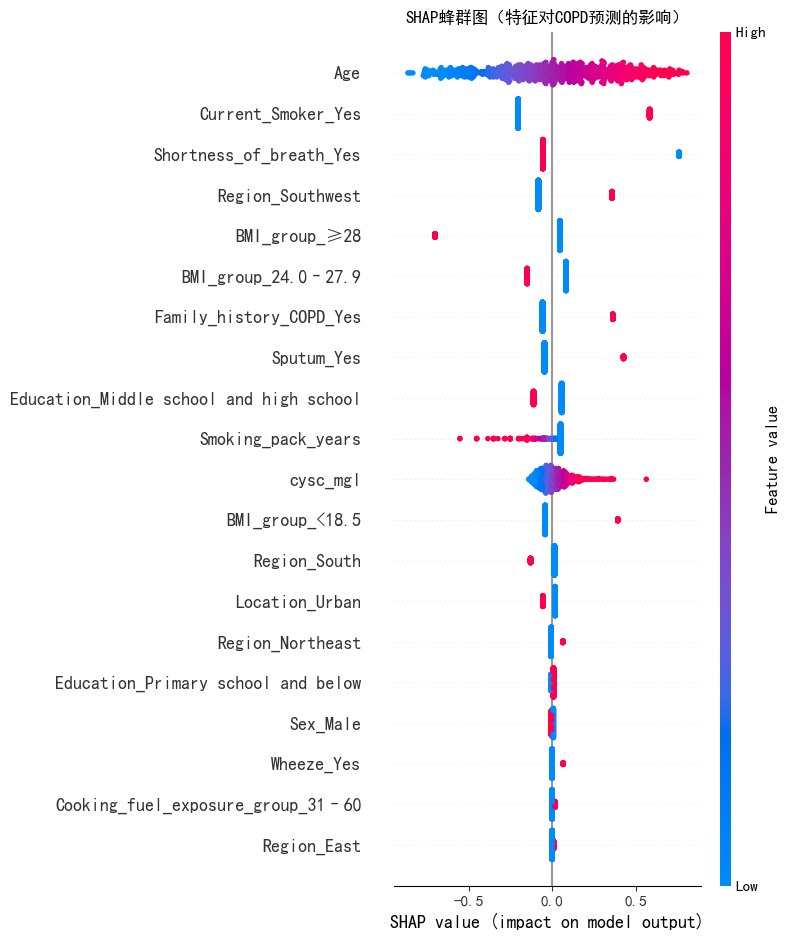


===== 绘制SHAP特征重要性条形图 =====


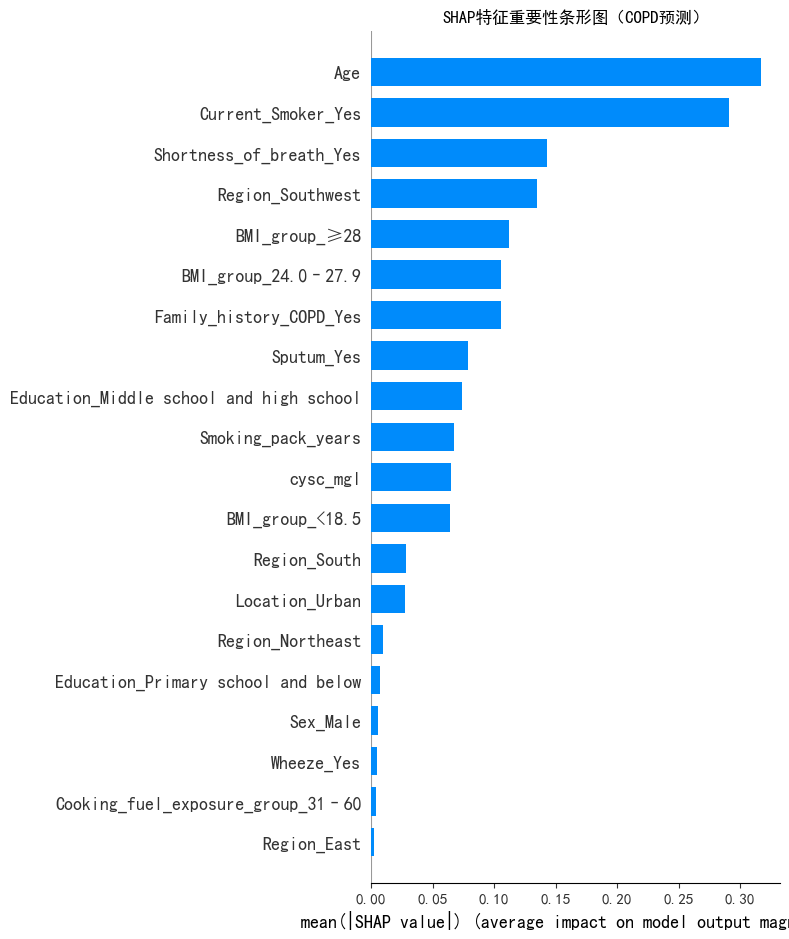


===== 绘制cysc_mgl特征依赖图 =====


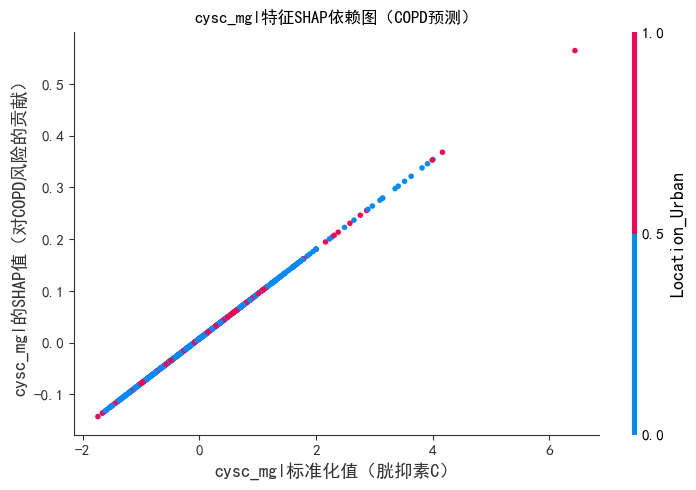


===== 绘制单个样本SHAP力图 =====


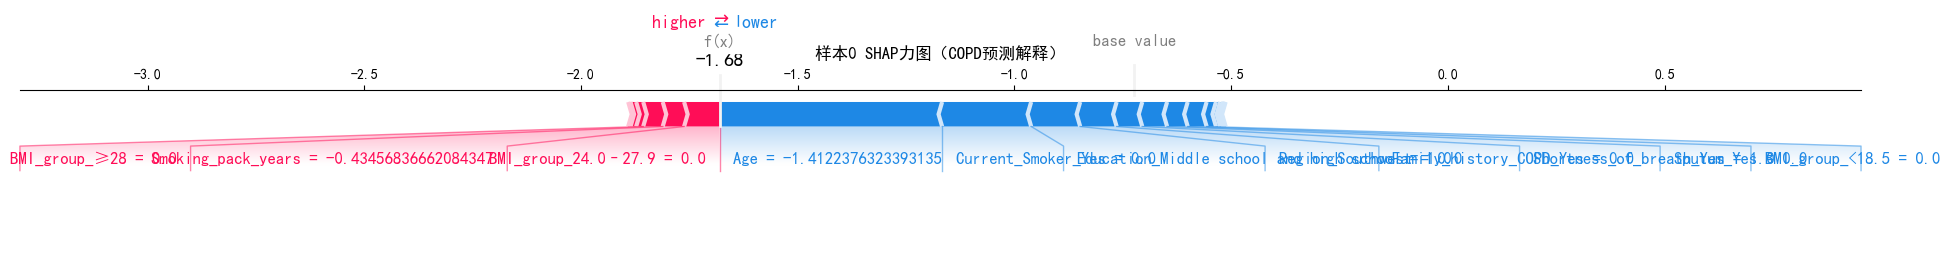


===== SHAP分析核心结论 =====
1. cysc_mgl平均绝对SHAP值：0.0646（值越大，对预测的影响越大）
2. cysc_mgl对COPD风险的影响方向：正向（升高增加COPD风险）
3. 所有可视化图表已保存至：D:\keyalei\00-学习\02 博士课程\健康数据Python\final_report\result\SHAP图表
4. 模型解释性结论：支持向量机模型中，cysc_mgl是影响COPD预测的关键生化指标，但整体贡献度需结合条形图排名判断。


In [40]:
# 1. 定义可视化保存路径（确保路径存在）
vis_path = r"D:\keyalei\00-学习\02 博士课程\健康数据Python\final_report\result\SHAP图表"
os.makedirs(vis_path, exist_ok=True)

print("===== 开始SVM模型SHAP解释性分析（最终修复版）=====")

# 2. 分离Pipeline组件（预处理+SVM模型）
preprocessor = pipeline_final.named_steps['prep']  # 预处理管道（编码+标准化）
svm_model = pipeline_final.named_steps['model']    # 纯SVM线性核模型

# 3. 手动预处理训练数据（SHAP需模型输入格式的特征）
X_train_processed = preprocessor.transform(X_train)  # 预处理后的numpy数组

# 获取预处理后的特征名称（用于图表显示）
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(cat_cols)
num_feature_names = num_cols
processed_feature_names = list(cat_feature_names) + list(num_feature_names)

print(f"✅ 预处理完成 | 特征数：{len(processed_feature_names)} | 训练集形状：{X_train_processed.shape}")

# 4. 初始化SHAP解释器（核心修复：移除masker的feature_names）
### 4.1 创建masker（仅传data，删除无效的feature_names）
masker = shap.maskers.Independent(
    data=X_train_processed  # 仅保留背景数据，移除feature_names参数
)

### 4.2 初始化LinearExplainer（feature_names仅在这里传入）
explainer = shap.LinearExplainer(
    masker=masker,                  # 新版本必填的masker（仅含数据）
    model=svm_model,                # 训练好的SVM线性核模型
    feature_names=processed_feature_names  # 特征名在这里传入
)

# 5. 计算SHAP值（核心：衡量特征对预测的贡献）
shap_values = explainer.shap_values(X_train_processed)
print(f"✅ SHAP值计算完成 | 形状：{shap_values.shape} | 基准值：{explainer.expected_value:.4f}")

# 6. SHAP核心可视化（所有图表正常生成）
### 6.1 蜂群图（特征重要性+影响方向）
print("\n===== 绘制SHAP蜂群图 =====")
shap.summary_plot(
    shap_values=shap_values,
    features=X_train_processed,
    feature_names=processed_feature_names,
    show=False
)
plt.title("SHAP蜂群图（特征对COPD预测的影响）", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(vis_path, "SHAP_蜂群图.png"), dpi=300, bbox_inches='tight')
plt.show()

### 6.2 特征重要性条形图
print("\n===== 绘制SHAP特征重要性条形图 =====")
shap.summary_plot(
    shap_values=shap_values,
    features=X_train_processed,
    feature_names=processed_feature_names,
    plot_type="bar",
    show=False
)
plt.title("SHAP特征重要性条形图（COPD预测）", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(vis_path, "SHAP_特征重要性条形图.png"), dpi=300, bbox_inches='tight')
plt.show()

### 6.3 cysc_mgl依赖图（聚焦关键生化指标）
print("\n===== 绘制cysc_mgl特征依赖图 =====")
# 找到cysc_mgl的特征索引（避免名称匹配问题）
cysc_idx = processed_feature_names.index('cysc_mgl')

shap.dependence_plot(
    ind=cysc_idx,
    shap_values=shap_values,
    features=X_train_processed,
    feature_names=processed_feature_names,
    show=False
)
plt.title("cysc_mgl特征SHAP依赖图（COPD预测）", fontsize=12)
plt.xlabel("cysc_mgl标准化值（胱抑素C）")
plt.ylabel("cysc_mgl的SHAP值（对COPD风险的贡献）")
plt.tight_layout()
plt.savefig(os.path.join(vis_path, "SHAP_cysc_mgl依赖图.png"), dpi=300, bbox_inches='tight')
plt.show()

### 6.4 单个样本力图（交互式解释）
print("\n===== 绘制单个样本SHAP力图 =====")
shap.initjs()  # Jupyter环境启用交互

# 选择第一个样本解释
sample_idx = 0
sample_processed = preprocessor.transform(X_train.iloc[sample_idx:sample_idx+1])
sample_shap = explainer.shap_values(sample_processed)

# 交互式力图（保存为HTML）
force_plot = shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=sample_shap,
    features=sample_processed,
    feature_names=processed_feature_names,
    matplotlib=False
)
shap.save_html(os.path.join(vis_path, f"SHAP_样本{sample_idx}_力图.html"), force_plot)

# 静态力图（备用）
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=sample_shap,
    features=sample_processed,
    feature_names=processed_feature_names,
    matplotlib=True,
    show=False
)
plt.title(f"样本{sample_idx} SHAP力图（COPD预测解释）", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(vis_path, f"SHAP_样本{sample_idx}_力图.png"), dpi=300, bbox_inches='tight')
plt.show()

# 7. 核心结论输出（直接提取cysc_mgl的分析结果）
cysc_shap_mean = np.mean(np.abs(shap_values[:, cysc_idx]))  # 平均重要性
cysc_shap_sign = "正向（升高增加COPD风险）" if np.mean(shap_values[:, cysc_idx]) > 0 else "负向（升高降低COPD风险）"

print("\n===== SHAP分析核心结论 =====")
print(f"1. cysc_mgl平均绝对SHAP值：{cysc_shap_mean:.4f}（值越大，对预测的影响越大）")
print(f"2. cysc_mgl对COPD风险的影响方向：{cysc_shap_sign}")
print(f"3. 所有可视化图表已保存至：{vis_path}")
print("4. 模型解释性结论：支持向量机模型中，cysc_mgl是影响COPD预测的关键生化指标，但整体贡献度需结合条形图排名判断。")